## 사전 설정

In [1]:
import os
import re
import json
import glob, shutil
import xml.etree.ElementTree as elemTree
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
    get_scheduler
)
from datasets import Dataset
from datasets import Image as ds_img
from polyleven import levenshtein

2023-08-02 16:08:59.458879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 16:09:00.069098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 데이터 압축 해제 및 정리

### Download Data

In [2]:
images_path = glob.glob('/home/ubuntu/kr-img2latex/data/train/images/*')
train_json_files = glob.glob('/home/ubuntu/kr-img2latex/data/train/annotations/*')

## Check Samples

In [3]:
sample_img = np.random.choice(images_path)
sample_json = sample_img.replace('images','annotations').replace('.png','.json')

In [4]:
Image.open(sample_img)

In [5]:
with open(Path(sample_json)) as jf:
  temp_json = json.load(jf)

In [6]:
temp_json

{'id': 'ddcabf5b-11d3-4fed-ba43-ba188c0ff6e5',
 'chapter_id': '1113',
 'material_type': '손글씨',
 'segments': [{'box': [[0, 0], [129, 0], [129, 27], [0, 27]],
   'type': '수식/텍스트',
   'type_detail': '텍스트/수식',
   'equation': '정답 : $\\displaystyle 32$  .'}]}

In [7]:
temp_json['segments']

[{'box': [[0, 0], [129, 0], [129, 27], [0, 27]],
  'type': '수식/텍스트',
  'type_detail': '텍스트/수식',
  'equation': '정답 : $\\displaystyle 32$  .'}]

$\int_{-1}^{1}\left|x^{3}-x\right| d x=\int_{-1}^{0}\left(x^{3}-x\right) d x+\int_{0}^{1}\left(-x^{3}+x\right) d x$

$\displaystyle {a_{n+1}}^{2} = a_{n+2} \times a_{n} \to $ 등비수열

$\displaystyle d$ 면

## Config

In [8]:
class CFG:

    # General
    debug = False
    num_proc = 4
    num_workers = 0
    gpus = 1

    # Data
    max_length = 360
    image_height = 480
    image_width = 480

    # Training
    epochs = 3 # 빠른 확인을 위해 1로 설정, 2로 설정하는 것을 추천
    val_check_interval = 1.0  # how many times we want to validate during an epoch
    check_val_every_n_epoch = 1
    gradient_clip_val = 1.0
    lr = 3e-05
    lr_scheduler_type = "linear"
    num_warmup_steps = 100
    seed = 42
    warmup_steps = 300
    output_path = "output"
    log_steps = 200
    batch_size = 1
    use_wandb = False

## Add Special Tokens

In [9]:
PROMPT_TOKEN = "<TPT>"
LINE_LEN_TOKEN_START = "<len>"
LINE_LEN_TOKEN_END = "</len>"
LINE_START = "<line>"
LINE_END = "</line>"
LATEX_START = "<latex>" # $ 가 라텍스 문법을 구분하는 토큰
LATEX_END = "</latex>"
HAND_TOKEN = "<hand>"
PRINT_TOKEN = "<print>"


SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    LINE_LEN_TOKEN_START,
    LINE_LEN_TOKEN_END,
    LINE_START,
    LINE_END,
    LATEX_START,
    LATEX_END,
    HAND_TOKEN,
    PRINT_TOKEN,
]

new_tokens = SEPARATOR_TOKENS

In [10]:
def get_gt_string(filepath: Union[str, os.PathLike]) -> Dict[str, str]:
    """
    Get the ground truth string and x-y data from the given JSON file.

    Args:
        filepath (str): The path to the JSON file

    Returns:
        dict: A dictionary containing the ground truth string, material type, and id
    """
    filepath = Path(filepath)

    with open(filepath, encoding='utf-8') as fp:
        data = json.load(fp)

    data_series = data["segments"]

    all_lines = []

    NON_OBJECT = False

    for d_line in data_series:
      if 'equation' not in d_line: # 도형, 그래프 제외
        NON_OBJECT = True
        break

      if '$' not in d_line['equation']:
        new_line = LINE_START + d_line['equation'] + LINE_END
      else:
        equation = d_line['equation'].split('$')
        latex_line = equation[0]
        for i, e in enumerate(equation[1:]):
          if i%2 == 0:
            latex_line += LATEX_START + e
          else:
            latex_line += LATEX_END + e

        new_line = LINE_START + latex_line + LINE_END

      all_lines.append(new_line)

    if not NON_OBJECT:
      if data['material_type'] == '손글씨':
        material_type = HAND_TOKEN
      else:
        material_type = PRINT_TOKEN

      len_of_lines = len(all_lines)
      string_lines = "".join(all_lines)

      gt_string = PROMPT_TOKEN + material_type + LINE_LEN_TOKEN_START + str(len_of_lines) + LINE_LEN_TOKEN_END + string_lines

      return {
          "ground_truth": gt_string,
          "material_type": data["material_type"],
          "id": data['id']
      }

    else:
      return False

In [11]:
get_gt_string(sample_json)

{'ground_truth': '<TPT><hand><len>1</len><line>정답 : <latex>\\displaystyle 32</latex>  .</line>',
 'material_type': '손글씨',
 'id': 'ddcabf5b-11d3-4fed-ba43-ba188c0ff6e5'}

## 데이터셋 구축

In [12]:
def gen_data(files: List[Union[str, os.PathLike]]) -> Dict[str, str]:
    """
    This function takes a list of json files and returns a generator that yields a
    dictionary with the ground truth string and the path to the image.

    Args:
        files (list): A list of json files

    Returns:
        generator: A generator that yields a dictionary with the ground truth string and
            the path to the corresponding image.
    """

    for f in files:

        result = get_gt_string(f)
        if result:
          yield {
              **result,
              "image_path": f.replace('annotations','images').replace('.json','.png')
          }


ds = Dataset.from_generator(
    gen_data, gen_kwargs={"files": train_json_files}, num_proc=CFG.num_proc
)

Found cached dataset generator (/home/ubuntu/.cache/huggingface/datasets/generator/default-9ecb45b6ad6bae9a/0.0.0)


## 이미지 사이즈 확인

In [13]:
def add_image_sizes(examples: Dict[str, Union[str, os.PathLike]]) -> Dict[str, List[int]]:
    """
    This function takes a dictionary of examples and adds the width and height of the
    image to the dictionary. This is to be used with the `Dataset.map` function.

    Args:
        examples (dict): A dictionary of examples (from `map` function)

    Returns:
        dict: The dictionary with the width and height of the image added
    """

    sizes = [Image.open(x).size for x in examples["image_path"]]

    width, height = list(zip(*sizes))

    return {
        "width": list(width),
        "height": list(height),
    }


ds = ds.map(add_image_sizes, batched=True, num_proc=CFG.num_proc)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/generator/default-9ecb45b6ad6bae9a/0.0.0/cache-12fda60cea449264_*_of_00004.arrow


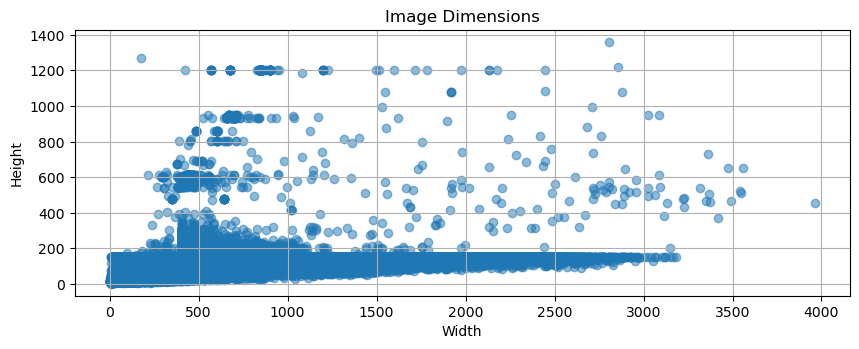

In [14]:
plt.figure(figsize=(10, 10))

plt.scatter(x=ds["width"], y=ds["height"], marker="o", alpha=0.5)

# Add axis labels
plt.xlabel("Width")
plt.ylabel("Height")

# Add a title
plt.title("Image Dimensions")

# Add gridlines
plt.grid(True)

# Set aspect ratio to be equal
plt.gca().set_aspect("equal", adjustable="box")

# Show the plot
plt.show()

## 모델 CONFIG

In [15]:
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = (CFG.image_height, CFG.image_width)
config.decoder.max_length = CFG.max_length

print(CFG.image_height, CFG.image_width, CFG.max_length)

480 480 360


In [16]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.image_processor.size = {
    "height": CFG.image_height,
    "width": CFG.image_width,
}

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## 토크나이징

In [17]:
tree = elemTree.parse('/home/ubuntu/kr-img2latex/vocab/tex_list.xml')
keywords = tree.find('AutoComplete').findall('KeyWord')
math_tokens = ['\\' + x.get('name') for x in keywords]

In [18]:
'\\int' in math_tokens

True

In [19]:
math_tokens[:10]

['\\Alph',
 '\\Alpha',
 '\\AltMacroFont',
 '\\AmSTeX',
 '\\Appendix',
 '\\Arrowvert',
 '\\AtBeginDocument',
 '\\AtEndClass',
 '\\AtEndDocument',
 '\\AtEndOfClass']

### UNK 토큰 핸들링

In [20]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    """
    Check for unknown tokens in the given examples.

    This function takes a dictionary containing a list of ground truth texts and
    tokenizes them using the processor's tokenizer. It then checks for any unknown
    tokens in the tokenized text and returns a dictionary containing a list of the
    unknown tokens for each example.

    Args:
        examples (dict): A dictionary containing a list of ground truth texts.
            Example: {"ground_truth": ["text1", "text2", ...]}

    Returns:
        dict: A dictionary containing a list of unknown tokens for each example.
            Example: {"unk_tokens": [["unk1", "unk2"], [], ["unk3"], ...]}
    """

    texts = examples["ground_truth"]

    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]

    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)

    return {"unk_tokens": unk_tokens}


unk = ds.map(check_for_unk, batched=True, num_proc=CFG.num_proc)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/generator/default-9ecb45b6ad6bae9a/0.0.0/cache-151748f673798c83_*_of_00004.arrow


In [21]:
# Let's look at only the examples with unknown tokens
unk = unk.filter(lambda x: len(x["unk_tokens"]) > 0, num_proc=CFG.num_proc)

print(len(unk))

unk[0]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/generator/default-9ecb45b6ad6bae9a/0.0.0/cache-de089c10de214211_*_of_00004.arrow


110055


{'ground_truth': '<TPT><hand><len>1</len><line><latex>36+24+20+16+4=100 \\%</latex></line>',
 'material_type': '손글씨',
 'id': '60150ee3-394e-4e43-9a1c-f8e7c657393f',
 'image_path': '/home/ubuntu/kr-img2latex/data/train/images/M_HS_e6_615_00434.png',
 'width': 1647,
 'height': 150,
 'unk_tokens': ['1']}

In [22]:
all_unk_tokens = [x for y in unk["unk_tokens"] for x in y]

# Counter(all_unk_tokens)

In [23]:
text_unk_tokens = list(set(all_unk_tokens))
text_unk_tokens.remove('1')

In [24]:
# 토큰 추가하기
num_added = processor.tokenizer.add_tokens(["<one>"] + new_tokens + math_tokens + text_unk_tokens)
print(num_added, "tokens added")

2491 tokens added


In [25]:
example_str = "<TPT><hand><len>1</len><line><latex>P(x=x)=\\frac{1}{10}(x-1)(x=1,2,3,4,5)</latex></line>"

temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
print("unk id:", processor.tokenizer.unk_token_id)

ids: [0, 57526, 57533, 57527, 1314, 57528, 57529, 57531, 40769, 7690, 40392, 9026, 40392, 11938, 9026, 58298, 1741, 3, 52613, 32650, 56548, 52613, 7690, 40392, 45391, 43440, 40392, 36966, 35815, 35934, 35815, 52872, 35815, 40711, 57532, 57530, 2]
tokenized: ['<TPT>', '<hand>', '<len>', '▁1', '</len>', '<line>', '<latex>', '▁P', '(', 'x', '=', 'x', ')', '=', '\\frac', '▁{', '1', '}', '{', '10', '}', '(', 'x', '-1', ')(', 'x', '=1', ',', '2', ',', '3,4', ',', '5)', '</latex>', '</line>']
decoded: <s><TPT><hand><len> 1</len><line><latex> P(x=x)=\frac {<unk>}{10}(x-1)(x=1,2,3,4,5)</latex></line></s>
unk id: 3


In [26]:
temp_ids[:10]

[0, 57526, 57533, 57527, 1314, 57528, 57529, 57531, 40769, 7690]

In [27]:
config.pad_token_id = processor.tokenizer.pad_token_id
config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_TOKEN])[0]
#

In [28]:
import cv2
import numpy as np
from PIL import Image, ImageDraw

def add_random_noise(image, intensity=50):
    """
    Add random noise to a PIL image.
    
    Parameters:
        image (PIL.Image.Image): The input image.
        intensity (int): The intensity of the noise. Higher values result in more noise.
    
    Returns:
        PIL.Image.Image: The image with added noise.
    """
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)

    # Generate random noise
    noise = np.random.randint(-intensity, intensity, size=image_array.shape, dtype=np.int16)

    # Add the noise to the image
    noisy_image_array = np.clip(image_array + noise, 0, 255).astype(np.uint8)

    # Convert the NumPy array back to a PIL image
    noisy_image = Image.fromarray(noisy_image_array)

    return noisy_image
        
def add_random_line_below_handwritten_text(image, text, text_position, line_color=(0, 0, 0), line_thickness=2):
    """
    Add a random horizontal line below handwritten text in a PIL image.

    Parameters:
        image (PIL.Image.Image): The input image.
        text (str): The handwritten text to be placed on the image.
        text_position (tuple): The (x, y) position to place the text.
        line_color (tuple): Color of the horizontal line (default is black).
        line_thickness (int): Thickness of the horizontal line (default is 2).

    Returns:
        PIL.Image.Image: The image with handwritten text and a random line below it.
    """
    # Create a draw object for the image
    draw = ImageDraw.Draw(image)

    # Draw the handwritten text on the image
    draw.text(text_position, text, fill=(0, 0, 0))

    # Generate a random y-coordinate for the line below the text
    line_y = text_position[1] + np.random.randint(20, 50)

    # Draw the random horizontal line below the text
    draw.line([(0, line_y), (image.width, line_y)], fill=line_color, width=line_thickness)

    return image

## Pixel Value, Input Id 전처리

In [29]:
import torch
import numpy as np
from functools import partial
from typing import Dict, Union, List
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, RandomHorizontalFlip, RandomRotation, RandomResizedCrop
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import random


one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
unk_token_id = processor.tokenizer.unk_token_id


def replace_unk_one_tokens_with_one(example_ids: List[int], example_tokens: List[str], one_token_id:int, unk_token_id:int) -> List[int]:
    """
    Replace unknown tokens that represent "1" with the correct token id.

    Args:
        example_ids (list): List of token ids for a given example
        example_tokens (list): List of tokens for the same given example
        one_token_id (int): Token id for the "<one>" token
        unk_token_id (int): Token id for the unknown token

    Returns:
        list: The updated list of token ids with the correct token id for "1"
    """

    temp_ids = []
    for id_, token in zip(example_ids, example_tokens):
        if id_ == unk_token_id and token == "1":
            id_ = one_token_id
        temp_ids.append(id_)
    return temp_ids


def preprocess(examples: Dict[str, str], processor: DonutProcessor, CFG: CFG) -> Dict[str, Union[torch.Tensor, List[int], List[str]]]:
    """
    Preprocess the given examples.

    This function processes the input examples by tokenizing the texts, replacing
    any unknown tokens that represent "1" with the correct token id, and loading
    the images.

    Args:
        examples (dict): A dictionary containing ground truth texts, image paths, and ids
        processor: An object responsible for tokenizing texts and processing images
        CFG: A configuration object containing settings and hyperparameters

    Returns:
        dict: A dictionary containing preprocessed images, token ids, and ids
    """

    pixel_values = []

    texts = examples["ground_truth"]

    ids = processor.tokenizer(
        texts,
        add_special_tokens=False,
        max_length=CFG.max_length,
        padding=True,
        truncation=True,
    ).input_ids

    if isinstance(texts, str):
        texts = [texts]

    tokens = [processor.tokenizer.tokenize(text, add_special_tokens=False) for text in texts]

    one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
    unk_token_id = processor.tokenizer.unk_token_id

    final_ids = [
        replace_unk_one_tokens_with_one(example_ids, example_tokens, one_token_id, unk_token_id)
        for example_ids, example_tokens in zip(ids, tokens)
    ]

    text_position = (10, 350)  # (x, y) position to place the text
    line_color = (0, 0, 0)  # Red color for the line (RGB)
    line_thickness = 3  

    for sample in examples["image_path"]:
        image = sample
        image = sample.convert("RGB").resize((CFG.image_width,CFG.image_height))
        image = RandomRotation(degrees=15)(image)
        image = add_random_noise(image, intensity=50)
        a = random.randint(0, 30)
        b = random.randint(450, 480)
        c = random.randint(50, 80)
        for i in range(a, b, c):
            text_position = (10, i)
            image = add_random_line_below_handwritten_text(image, texts, text_position, line_color, line_thickness)
        pixel_values.append(processor(image, random_padding=True).pixel_values)

    return {
        "pixel_values": torch.tensor(np.vstack(pixel_values)),
        "input_ids": final_ids,
        "id": examples["id"],
    }


image_ds = ds.cast_column("image_path", ds_img())
image_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [30]:
sample = image_ds[[0, 1, 2]]

print(sample["pixel_values"].shape)
print(processor.decode(sample["input_ids"][2]))
print(len(sample["input_ids"][2]))
print(processor.tokenizer.convert_ids_to_tokens(sample["input_ids"][2]))

torch.Size([3, 3, 480, 480])
<TPT><print><len> 5</len><line> 쪽 학업</line><line><latex>\displaystyle 02</latex> <latex>\displaystyle 5</latex></line><line> 자연수는</line><line><latex>\displaystyle 3\frac {2}{15}-1\frac {2}{3} = 2\frac {17}{15}-1\frac {2}{3} = 1\frac {7}{15}</latex> </line><line><latex>\displaystyle 5</latex> <latex>\displaystyle \frac {<one>}{2},\frac {<one>}{5}</latex></line>
100
['<TPT>', '<print>', '<len>', '▁5', '</len>', '<line>', '▁', '쪽', '▁학', '업', '</line>', '<line>', '<latex>', '\\displaystyle', '▁02', '</latex>', '▁', '<latex>', '\\displaystyle', '▁5', '</latex>', '</line>', '<line>', '▁자연', '수는', '</line>', '<line>', '<latex>', '\\displaystyle', '▁3', '\\frac', '▁{', '2', '}', '{', '15', '}', '-1', '\\frac', '▁{', '2', '}', '{', '3', '}', '▁=', '▁2', '\\frac', '▁{', '17', '}', '{', '15', '}', '-1', '\\frac', '▁{', '2', '}', '{', '3', '}', '▁=', '▁1', '\\frac', '▁{', '7', '}', '{', '15', '}', '</latex>', '▁', '</line>', '<line>', '<latex>', '\\displaystyle', '▁5'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


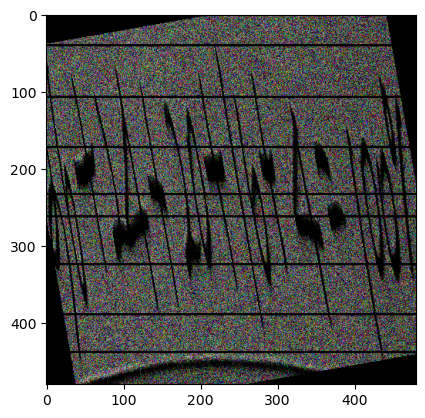

In [31]:
plt.imshow(sample["pixel_values"][0].permute(1,2,0))

## Splits 만들기

In [32]:
# # train_test_split 사용하는 방법
# from sklearn.model_selection import train_test_split

# traIn_ds, val_ds = train_test_split(ds, test_size=0.1, random_state=CFG.seed)

# train_ds = traIn_ds.cast_column("image_path", ds_img())
# train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

# val_gt_ds = val_ds
# val_ds = val_ds.cast_column("image_path", ds_img())
# val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [33]:
skf = StratifiedKFold(n_splits=80)

fold_idxs = []

for _, val_idxs in skf.split(ds["material_type"], y=ds["material_type"]):
    fold_idxs.append(val_idxs)

In [34]:
fold_idxs

[array([   0,    1,    2, ..., 1685, 1689, 1692]),
 array([1557, 1558, 1559, ..., 3466, 3471, 3475]),
 array([3095, 3097, 3099, ..., 5041, 5049, 5051]),
 array([4673, 4674, 4676, ..., 6688, 6698, 6705]),
 array([6247, 6248, 6249, ..., 8260, 8265, 8269]),
 array([7838, 7839, 7841, ..., 9730, 9737, 9743]),
 array([ 9449,  9450,  9451, ..., 11278, 11279, 11281]),
 array([11080, 11081, 11082, ..., 12752, 12763, 12764]),
 array([12695, 12696, 12697, ..., 14362, 14363, 14364]),
 array([14282, 14283, 14284, ..., 15955, 15957, 15958]),
 array([15868, 15869, 15871, ..., 17478, 17479, 17481]),
 array([17466, 17472, 17480, ..., 19102, 19103, 19104]),
 array([18949, 18953, 18954, ..., 20678, 20679, 20681]),
 array([20542, 20557, 20569, ..., 22263, 22265, 22266]),
 array([22203, 22204, 22208, ..., 23880, 23881, 23882]),
 array([23691, 23695, 23700, ..., 25424, 25425, 25428]),
 array([25409, 25412, 25423, ..., 27016, 27017, 27018]),
 array([26990, 26991, 26998, ..., 28638, 28639, 28641]),
 array([28

In [35]:
fold = 0
train_extracted = ds.select(
    list(chain(*[x for i, x in enumerate(fold_idxs) if i != fold]))
)

train_ds = train_extracted.cast_column("image_path", ds_img())
train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

val_gt_ds = ds.select(fold_idxs[fold])
val_ds = val_gt_ds.cast_column("image_path", ds_img())
val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

gt_material_type = val_gt_ds["material_type"]
gt_texts = val_gt_ds['ground_truth']
gt_ids = val_gt_ds["id"]

i = 0
print(gt_material_type[i])
print(gt_texts[i])
print(gt_ids[i])
print(Counter(gt_material_type))

손글씨
<TPT><hand><len>1</len><line><latex>36+24+20+16+4=100 \%</latex></line>
60150ee3-394e-4e43-9a1c-f8e7c657393f
Counter({'손글씨': 1217, '인쇄체': 372})


## `ids` 가 batch 마다 전부 같은 길이를 가지도록 하는 collate function

In [36]:
pad_token_id = processor.tokenizer.pad_token_id


def collate_fn(samples: List[Dict[str, Union[torch.Tensor, List[int], str]]]) -> Dict[str, Union[torch.Tensor, List[str]]]:
    """
    Custom collate function for DataLoader.

    This function takes a list of samples and combines them into a batch with
    properly padded input_ids.

    Args:
        samples (List[Dict[str, Union[torch.Tensor, List[int], str]]]):
            A list of samples, where each sample is a dictionary containing
            "pixel_values" (torch.Tensor), "input_ids" (List[int]), and "id" (str).

    Returns:
        Dict[str, Union[torch.Tensor, List[str]]]:
            A dictionary containing the combined pixel values, padded input_ids, and ids.
    """

    batch = {}

    batch["pixel_values"] = torch.stack([x["pixel_values"] for x in samples])

    max_length = max([len(x["input_ids"]) for x in samples])

    # Make a multiple of 8 to efficiently use the tensor cores
    if max_length % 8 != 0:
        max_length = (max_length // 8 + 1) * 8

    input_ids = [
        x["input_ids"] + [pad_token_id] * (max_length - len(x["input_ids"]))
        for x in samples
    ]

    labels = torch.tensor(input_ids)
    labels[labels == pad_token_id] = -100 # ignore loss on padding tokens
    batch["labels"] = labels

    batch["id"] = [x["id"] for x in samples]

    return batch

## Dataloaders

- Validation은 generation을 사용하기 때문에 굉장히 느리다.
- 따라서 sample의 일부를 적게만 사용한다.

In [37]:
if CFG.debug:
    train_ds = train_ds.select(range(100))
    val_ds = val_ds.select(range(100))

train_dataloader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)

num_training_steps = len(train_dataloader) * CFG.epochs // CFG.gpus

batch = next(iter(train_dataloader))

batch.keys(), [(k, v.shape) for k, v in batch.items() if k != "id"]

(dict_keys(['pixel_values', 'labels', 'id']),
 [('pixel_values', torch.Size([1, 3, 480, 480])),
  ('labels', torch.Size([1, 32]))])

In [38]:
batch['pixel_values'][0]

tensor([[[-1.0000, -0.7255, -0.9059,  ..., -1.0000, -1.0000, -0.9922],
         [-0.9373, -1.0000, -1.0000,  ..., -1.0000, -0.9686, -0.7804],
         [-0.8902, -0.6157, -0.8667,  ..., -0.6549, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -0.7725,  ..., -0.6706, -0.9529, -0.9294],
         [-1.0000, -0.7647, -1.0000,  ..., -1.0000, -0.8431, -0.7569],
         [-1.0000, -1.0000, -0.7098,  ..., -1.0000, -1.0000, -0.9137]],

        [[-1.0000, -1.0000, -0.7882,  ..., -0.7098, -1.0000, -1.0000],
         [-0.9373, -1.0000, -0.8510,  ..., -1.0000, -0.8745, -1.0000],
         [-0.7490, -1.0000, -1.0000,  ..., -1.0000, -0.8980, -1.0000],
         ...,
         [-0.6392, -0.8824, -1.0000,  ..., -0.8824, -1.0000, -1.0000],
         [-1.0000, -0.6784, -1.0000,  ..., -0.8980, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.6314, -0.6627, -1.0000]],

        [[-0.6314, -1.0000, -0.9216,  ..., -1.0000, -0.8902, -0.6863],
         [-0.8588, -0.7255, -1.0000,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


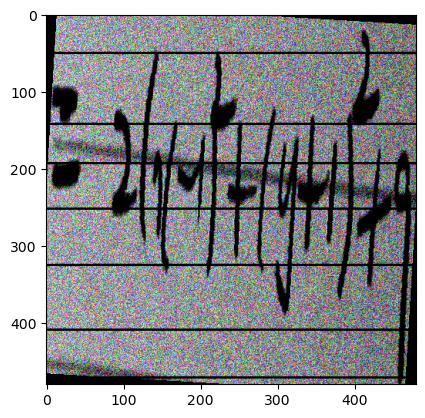

In [39]:
plt.imshow(batch['pixel_values'][0].permute(1,2,0))

In [40]:
batch['labels'][0]

tensor([57526, 57533, 57527,  1314, 57528, 57529, 57531, 42990, 44648,  7690,
        40392, 45391, 11938, 53163, 32650, 35934, 52613,  8053,  7690, 43634,
        25116, 11938, 53163, 32650, 35934, 52613,  8053,  3200, 57532, 57530,
         -100,  -100])

## Metric을 계산하기 위한 function

In [41]:
def rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Root Mean Square Error.
    """
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def sigmoid(x: float) -> float:
    """
    Calculate the sigmoid function for the given value.

    Args:
        x (float): The input value.

    Returns:
        float: The result of the sigmoid function.
    """
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the normalized Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The normalized Root Mean Square Error.
    """
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)


def normalized_levenshtein_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the normalized Levenshtein distance between two lists of strings.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The normalized Levenshtein distance.
    """
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)

def score_series(
    y_true: List[Union[float, str]], y_pred: List[Union[float, str]]
) -> float:
    """
    Calculate the score for a series of true and predicted values.

    Args:
        y_true (List[Union[float, str]]): The true values.
        y_pred (List[Union[float, str]]): The predicted values.

    Returns:
        float: The score for the series.
    """
    if len(y_true) != len(y_pred):
        pass
        #return 0.0
    if isinstance(y_true[0], str):
        return f1_score(y_true, y_pred)
    else:
        # Since this is a generative model, there is a chance it doesn't produce a float.
        # In that case, we return 0.0.
        try:
            return mse(list(map(float, y_true)), list(map(float, y_pred)))
            # return normalized_rmse(y_true, list(map(float, y_pred)))
        except:
            return 0.0


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.

    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series`
        should be either arrays of floats or arrays of strings.

    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError(
            "Must have exactly one prediction for each ground-truth instance."
        )
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(
        ground_truth.itertuples(index=False), predictions.itertuples(index=False)
    )
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        # if gt_type != pred_type:  # Check material_type condition
        #     scores.append(0.0)
        # else:  # Score with RMSE or Levenshtein as appropriate
        scores.append(score_series(gt_series, pred_series))

    ground_truth["score"] = scores

    grouped = ground_truth.groupby("material_type", as_index=False)["score"].mean()

    material_type2score = {
        material_type: score
        for material_type, score in zip(grouped["material_type"], grouped["score"])
    }

    return np.mean(scores), material_type2score

def f1_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the F1 score between the true and predicted values.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The F1 score.
    """
    true_set = set(y_true)
    pred_set = set(y_pred)
    intersection = true_set.intersection(pred_set)
    precision = len(intersection) / len(pred_set) if len(pred_set) > 0 else 0.0
    recall = len(intersection) / len(true_set) if len(true_set) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return f1

def mse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Mean Squared Error (MSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Mean Squared Error.
    """
    return np.mean(np.square(np.subtract(y_true, y_pred)))

def string2doublet(pred_string: str) -> Tuple[str, List[str]]:
    """
    Convert a prediction string to a doublet of material type, and text.

    Args:
        pred_string (str): The prediction string.

    Returns:
        Tuple[str, List[str]]: A doublet of material type, and text.
    """

    material_type = "인쇄체"
    for tok in [HAND_TOKEN, PRINT_TOKEN]:
        if tok in pred_string:
            if tok == HAND_TOKEN:
                material_type = '손글씨'
            else:
                material_type = '인쇄체'

    pred_string = re.sub(r"<one>", "1", pred_string)

    text = pred_string

    if len(text) == 0:
        return material_type, []

    return material_type, text


def validation_metrics(val_outputs: List[str], val_ids: List[str], gt_df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate validation metrics for a set of outputs, ids, and ground truth dataframe.

    Args:
        val_outputs (List[str]): A list of validation outputs.
        val_ids (List[str]): A list of validation ids.
        gt_df (pd.DataFrame): The ground truth dataframe.

    Returns:
        Dict[str, float]: A dictionary containing the validation scores.
    """
    pred_doublets = []

    for example_output in val_outputs:
        pred_doublets.append(string2doublet(example_output))

    # Comment[전현욱] : 생각해보니 굳이 material type 별로 점수를 나눌 필요가 있을까 싶다
    pred_df = pd.DataFrame(
        index=val_ids,
        data={
            "text": [x[1] for x in pred_doublets],
            "material_type": [x[0] for x in pred_doublets],
        },
    )

    overall_score, material_type2score = benetech_score(
        gt_df.loc[pred_df.index.values], pred_df
    )

    return {
        "val_score": overall_score,
        **{f"{k}_score": v for k, v in material_type2score.items()},
    }

## Lightning Module

In [42]:
import pytorch_lightning as pl
import gc
from transformers import PreTrainedTokenizerBase, PreTrainedModel

class DonutModelPLModule(pl.LightningModule):
    def __init__(self, processor: PreTrainedTokenizerBase, model: PreTrainedModel, gt_df: pd.DataFrame, num_training_steps: int):
        """
        A PyTorch Lightning module for the DonutModel.

        Args:
            processor (PreTrainedTokenizerBase): The tokenizer/processor for the model.
            model (PreTrainedModel): The pretrained model.
            gt_df (pd.DataFrame): The ground truth dataframe.
            num_training_steps (int): The number of training steps.
        """
        super().__init__()
        self.processor = processor
        self.model = model
        self.gt_df = gt_df
        self.num_training_steps = num_training_steps

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        gc.collect()
        torch.cuda.empty_cache()

        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int, dataset_idx: int = 0) -> None:
        pixel_values = batch["pixel_values"]
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full(
            (batch_size, 1),
            self.model.config.decoder_start_token_id,
            device=self.device,
        )

        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        self.val_outputs.extend(
            self.processor.tokenizer.batch_decode(outputs.sequences)
        )
        self.val_ids.extend(batch["id"])

    def on_validation_start(self) -> None:
        gc.collect()
        torch.cuda.empty_cache()

        self.val_outputs, self.val_ids = [], []

    def on_validation_epoch_end(self) -> None:

        metrics = validation_metrics(self.val_outputs, self.val_ids, self.gt_df)
        print("\n", metrics)

        self.log_dict(metrics)

        self.val_outputs, self.val_ids = [], []

    def configure_optimizers(self) -> torch.optim.Optimizer:

        optimizer = torch.optim.Adam(self.parameters(), lr=CFG.lr, betas=(0.9, 0.999), eps=1e-08)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
        
        return optimizer

### Model, Ground Truth DataFrame 생성

In [43]:
gt_material_type = val_gt_ds["material_type"]
gt_texts = val_gt_ds["ground_truth"]
gt_ids = val_gt_ds["id"]

gt_df = pd.DataFrame(
    index=gt_ids,
    data={
        "text": gt_texts,
        "material_type": gt_material_type,
    },
)


model = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base", config=config, ignore_mismatched_sizes=True
)
model.decoder.resize_token_embeddings(len(processor.tokenizer))
model_module = DonutModelPLModule(processor, model, gt_df, num_training_steps)

In [44]:
# Check if it works
outputs = model(batch["pixel_values"], labels=batch["labels"])

In [45]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

checkpoint_cb = ModelCheckpoint(CFG.output_path)

loggers = []

trainer = pl.Trainer(
        accelerator="gpu",
        devices=CFG.gpus,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[checkpoint_cb],
        logger=loggers
)

/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [46]:
torch.set_float32_matmul_precision('high')

In [ ]:
trainer.fit(model_module, train_dataloaders=train_dataloader)

/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/ubuntu/kr-img2latex/model/output exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 204 M 
----------------------------------------------------
204 M     Trainable params
0         Non-trainable params
204 M     Total params
817.611   Total estimated model params size (MB)
/home/ubuntu/.conda/envs/team_conda/lib/python3.10/site-packages/pytorch_lightning/trainer/c

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.validate(model_module, dataloaders=val_dataloader)

In [ ]:
# check gt label
for i, batch in enumerate(val_dataloader):
  if i == 10:
    break
  for b in batch['labels']:
    tokens = []
    for token in b:
      if token != -100:
        tokens.append(token)
    print(processor.decode(tokens))

## Test

In [ ]:
test_img_paths = glob.glob('/home/ubuntu/kr-img2latex/data/test/images/*.png')
sample_test_img_path = np.random.choice(test_img_paths)
sample_test_json_file = sample_test_img_path.replace('images','annotations').replace('.png','.json')

In [ ]:
# for personal data
# sample_test_img_path = '/content/mypic.jpg'

In [ ]:
sample_test_img = Image.open(sample_test_img_path).convert("RGB").resize((CFG.image_width, CFG.image_height))
sample_test_img

In [ ]:
pixel_values = processor(sample_test_img, random_padding=True).pixel_values
pixel_values = torch.FloatTensor(pixel_values).to('cuda')

decoder_input_ids = torch.full(
            (1, 1),
            model.config.decoder_start_token_id,
            device='cuda',
)

model.cuda()

outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
)

In [ ]:
processor.tokenizer.batch_decode(outputs.sequences)

In [ ]:
get_gt_string(sample_test_json_file)['ground_truth']

In [ ]:
normalized_levenshtein_score(processor.tokenizer.batch_decode(outputs.sequences),
                             [get_gt_string(sample_test_json_file)['ground_truth']])

## Save Model

In [ ]:
model_module.model.save_pretrained('/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-1, len, augmentated/model')
model_module.processor.save_pretrained('/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-1, len, augmentated/processor')
config.save_pretrained('/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-1, len, augmentated/config')

## Load Model

In [ ]:
new_config = VisionEncoderDecoderConfig.from_pretrained("/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-1, len, augmentated/config")
new_processor = DonutProcessor.from_pretrained("/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-1, len, augmentated/processor")
new_model =  VisionEncoderDecoderModel.from_pretrained(
    "/home/ubuntu/kr-img2latex/pretrained/main/epoch-2, batch-1, len, augmentated/model", config=new_config
)

In [ ]:
new_model.cuda()

In [ ]:
new_model_module = DonutModelPLModule(new_processor, new_model, gt_df, num_training_steps)

In [ ]:
new_trainer = pl.Trainer(
        accelerator="gpu",
        devices=CFG.gpus,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[checkpoint_cb],
        logger=loggers
)

In [ ]:
new_trainer.validate(new_model_module, dataloaders=val_dataloader)

## For Debug

In [ ]:
test_img_paths = glob.glob('/home/ubuntu/kr-img2latex/data/test/images/*.png')
sample_test_img_path = np.random.choice(test_img_paths)
sample_test_json_file = sample_test_img_path.replace('images','annotations').replace('.png','.json')
sample_test_img = Image.open(sample_test_img_path).convert("RGB").resize((CFG.image_width, CFG.image_height))
sample_test_img

In [ ]:
pixel_values = new_processor(sample_test_img, random_padding=True).pixel_values
pixel_values = torch.FloatTensor(pixel_values).to('cuda')

decoder_input_ids = torch.full(
            (1, 1),
            new_model.config.decoder_start_token_id,
            device='cuda',
)

new_model.cuda()

outputs = new_model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=new_processor.tokenizer.pad_token_id,
            eos_token_id=new_processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[new_processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
)

tmp = new_processor.tokenizer.batch_decode(outputs.sequences)[0].replace(' ','')[:34]
Line_no = int(re.findall(r'\d+', tmp)[0])
Line_no

In [ ]:
get_gt_string(sample_test_json_file)['ground_truth'][:29]

In [ ]:
normalized_levenshtein_score(processor.tokenizer.batch_decode(outputs.sequences),
                             [get_gt_string(sample_test_json_file)['ground_truth']])